# Concrete Crack Classification, Detection, Segmentation

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report


import glob
import os

positive_dir = Path('Data/Positive')
negative_dir = Path('Data/Negative')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

2023-02-12 19:40:44.808970: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-12 19:40:45.498901: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dylfazo/miniconda3/envs/tf/lib/
2023-02-12 19:40:45.499010: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dylfazo/miniconda3/envs/tf/lib/
2023-02-12 19:40:45.499018: W tensorflow/compiler/tf

In [2]:
# Helper Callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.999):
            print("\nReached 99.9% Val Accuracy so cancelling training!")
            self.model.stop_training = True

In [3]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2023-02-12 19:40:46.021072: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-12 19:40:46.132020: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-12 19:40:46.155049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-12 19:40:46.155443: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_nod

In [4]:


path = 'Data/'
path_all = list(glob.glob(path+'**/*jpg'))
path_Negative = path + 'Negative/*.jpg'
path_Positive = path + 'Positive/*.jpg'



In [5]:



labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_all))
file_Path = pd.Series(path_all, name='File_Path').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([file_Path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()





,File_Path,Label
0,Data/Negative/12088.jpg,Negative
1,Data/Negative/09292.jpg,Negative
2,Data/Negative/05023.jpg,Negative
3,Data/Negative/05159.jpg,Negative
4,Data/Positive/13364_1.jpg,Positive


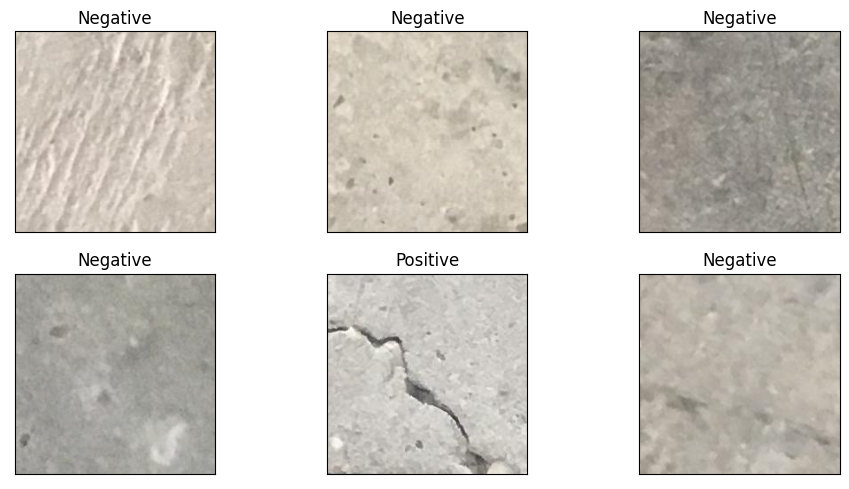

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [7]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

In [8]:
image_color_channel_size = 255
image_size = (100,100)
batch_size =128
def gen(train,test):
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                        rescale=1./image_color_channel_size,
                        validation_split=0.2)
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                       rescale=1./image_color_channel_size,)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=42
        )
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False,
        seed=42
    )
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Label',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False
    )
    return train_gen, valid_gen, test_gen

In [9]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

In [10]:
train_gen, valid_gen, test_gen =  gen(train_df, test_df)

Found 32000 validated image filenames belonging to 2 classes.
Found 32000 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [11]:
def make_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same')(inputs)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dense(128,activation="relu")(x)
    x = tf.keras.layers.Dense(128,activation="relu")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    flat = tf.keras.layers.Flatten()(x)
    
    
    
    outputs = tf.keras.layers.Dense(2, activation='softmax', name='softmax')(flat)

    return tf.keras.Model(inputs, outputs)


# tf.debugging.set_log_device_placement(True)


model = make_model(input_shape=image_size + (3,), num_classes=2)


model.compile(optimizer=tf.keras.optimizers.Adam(0.003 * 32/ 512), 
         loss='categorical_crossentropy', 
         metrics=['accuracy']
        )

2023-02-12 19:40:47.771871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-12 19:40:47.772472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-12 19:40:47.772869: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-12 19:40:47.773546: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-12 19:40:47.773971: I tensorflow/compile

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 activation (Activation)     (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        18496     
                                                             

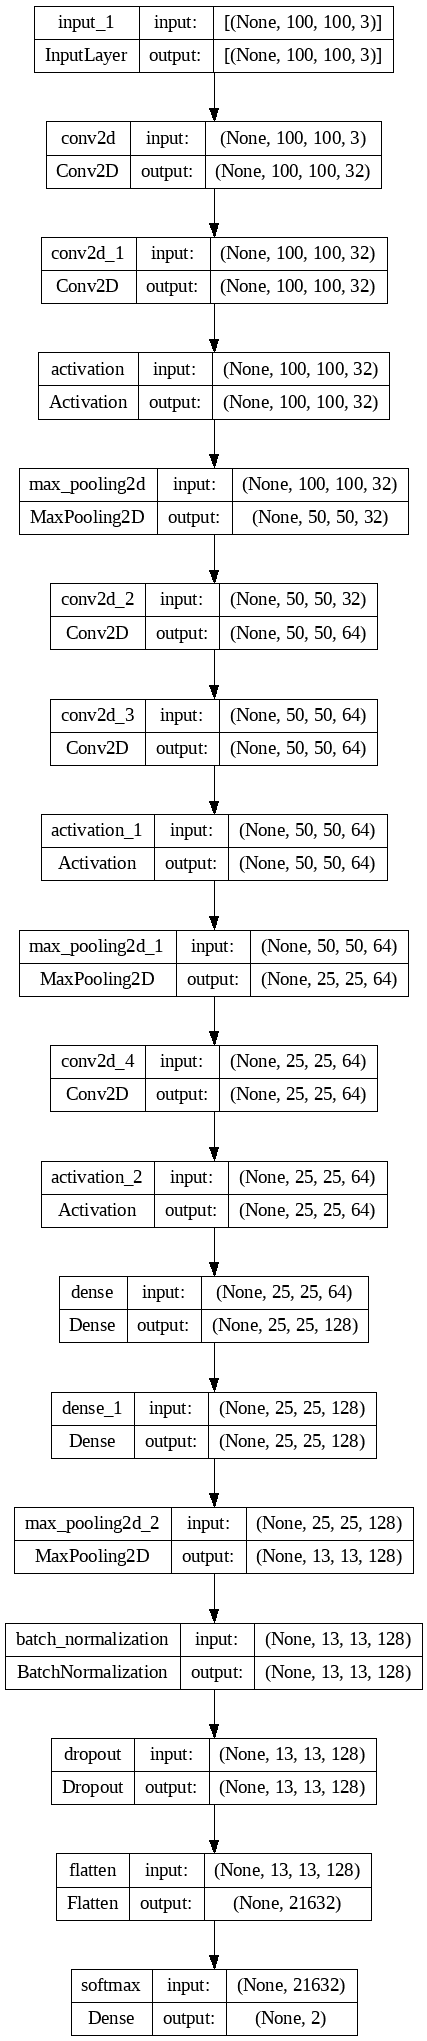

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

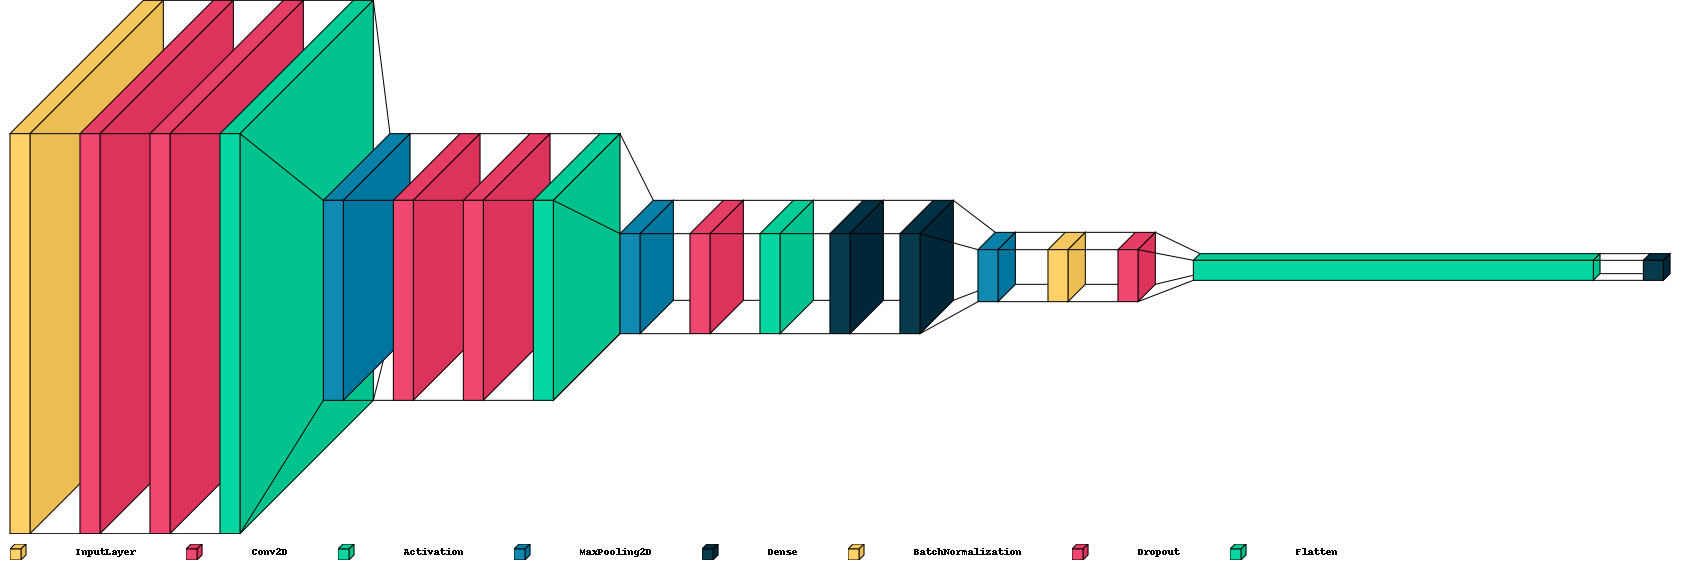

In [14]:
import visualkeras

visualkeras.layered_view(model ,spacing=50,legend=True)

In [15]:
until_max_callbacks = myCallback()

In [16]:
import os
checkpoint_name = 'weights/Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
m_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')

In [17]:
# model = tf.keras.models.load_model('classifier_cnn.h5')

In [18]:
%%time
hist = model.fit(train_gen, epochs=30, batch_size=32 ,callbacks=[until_max_callbacks], validation_data=valid_gen)

Epoch 1/30


2023-02-12 19:40:49.611898: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-02-12 19:40:50.284175: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-12 19:40:52.304657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-12 19:40:52.360859: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fc8f5290200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-12 19:40:52.360900: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2023-02-12 19:40:52.364923: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:

250/250 [==============================] - 32s 107ms/step - loss: 0.1227 - accuracy: 0.9506 - val_loss: 0.4034 - val_accuracy: 0.6160
Epoch 2/30
250/250 [==============================] - 26s 103ms/step - loss: 0.0272 - accuracy: 0.9920 - val_loss: 0.5614 - val_accuracy: 0.5799
Epoch 3/30
250/250 [==============================] - 34s 135ms/step - loss: 0.0173 - accuracy: 0.9947 - val_loss: 0.1419 - val_accuracy: 0.9592
Epoch 4/30
250/250 [==============================] - 27s 108ms/step - loss: 0.0179 - accuracy: 0.9949 - val_loss: 0.3847 - val_accuracy: 0.9217
Epoch 5/30
250/250 [==============================] - 27s 110ms/step - loss: 0.0134 - accuracy: 0.9956 - val_loss: 0.0310 - val_accuracy: 0.9900
Epoch 6/30
250/250 [==============================] - 27s 106ms/step - loss: 0.0107 - accuracy: 0.9962 - val_loss: 0.0059 - val_accuracy: 0.9979
Epoch 7/30
250/250 [==============================] - 29s 115ms/step - loss: 0.0085 - accuracy: 0.9973 - val_loss: 0.0073 - val_accuracy: 0.9

In [19]:
def plot(history,df_test,test_gen,train_gen): # Credit Hamza Manssor
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
        
    # Predict Data Test
    
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(df_test.Label,pred)
    clr = classification_report(df_test.Label, pred, target_names=["NEGATIVE", "POSITIVE"])
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df_test.File_Path.iloc[i+1]))
        ax.set_title(f"True: {df_test.Label.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix for Crack Classification Network')
    plt.show()
    return history

63/63 [==============================] - 3s 51ms/step
              precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00      3956
    POSITIVE       1.00      1.00      1.00      4044

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



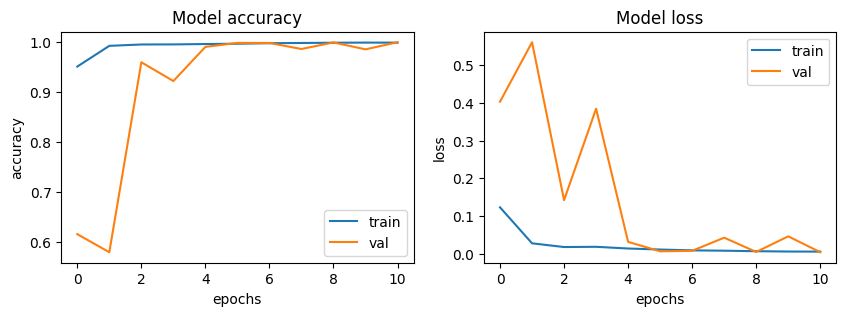

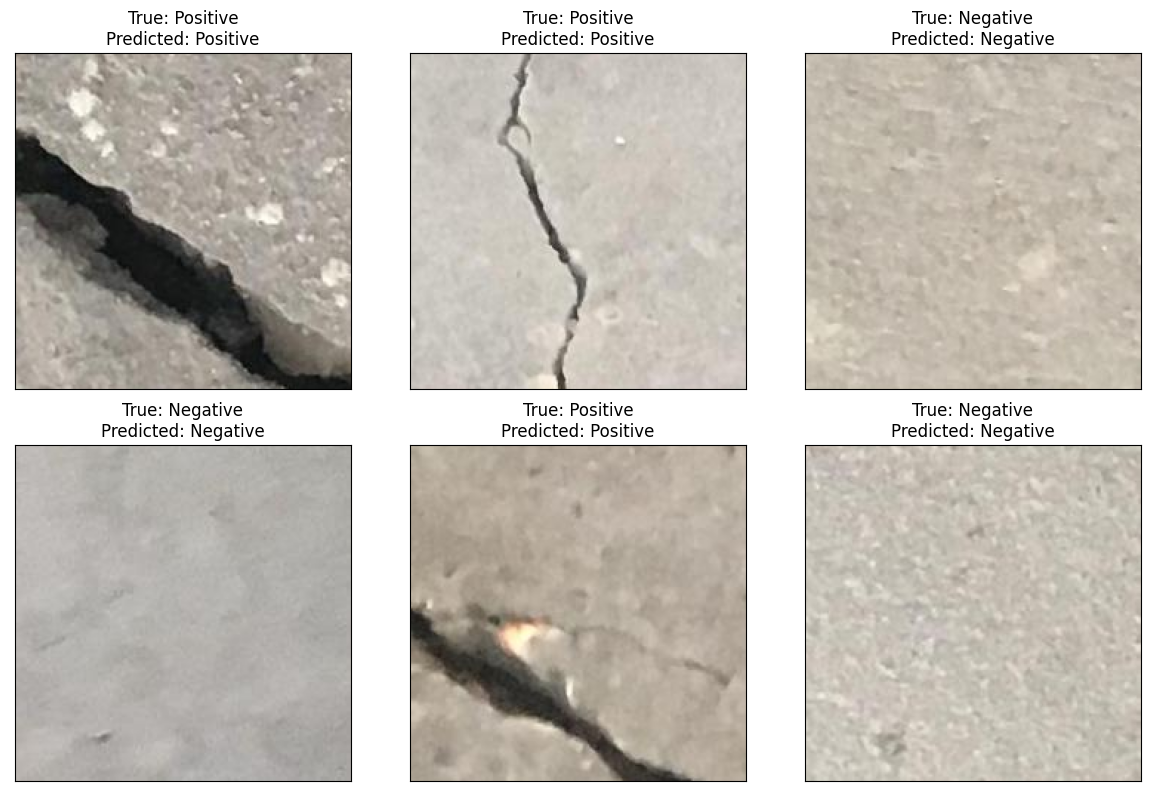

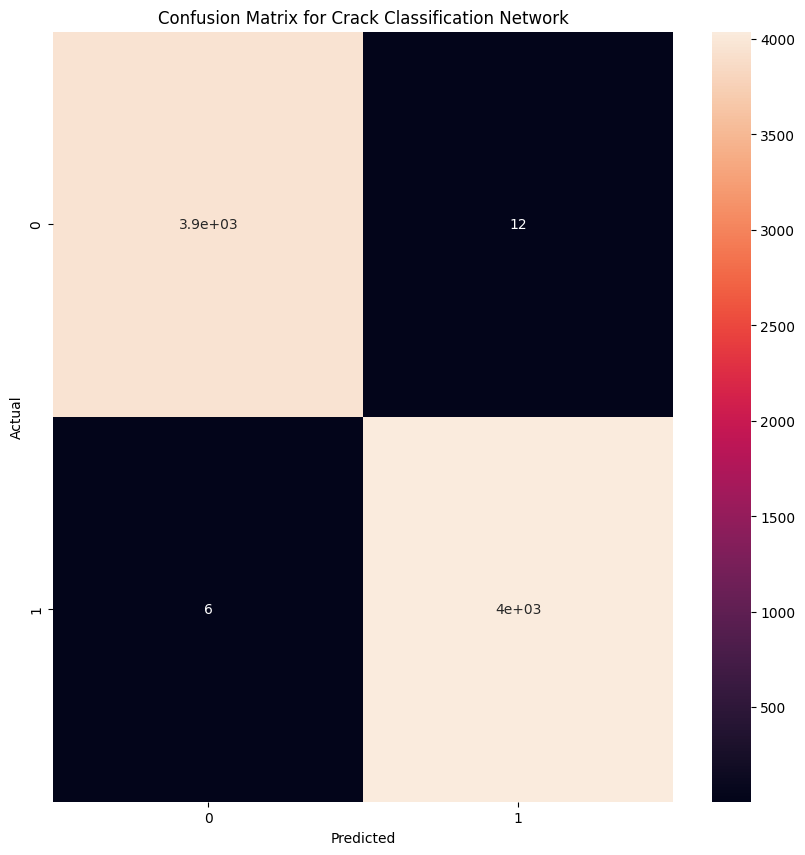

In [20]:
plot(hist, test_df, test_gen, train_gen)

In [21]:
result = result_test(test_gen,model)

    Test Loss: 0.01090
Test Accuracy: 99.77%


## CNN-classifer -> Segmentation -> Draw segmentation

Now I am going to apply a secondary neural network that will be trained on the predictions on the first in order to segment mask cracks and understand our true vs false positives.




In [22]:
# Create Segmentation Dataframe from results of first network


# Collect first model predictions 
first_network_predictions = model.predict(test_gen)
first_network_predictions = np.argmax(first_network_predictions,axis=1)

pred_df = test_df.copy()
# Apply the predicted labels to our test set
pred_df['Predicted_Label'] = first_network_predictions
pred_labels_str = np.array(["0" if x == 0 else "1" for x in pred_df.Predicted_Label])
pred_df.Predicted_Label = pred_labels_str
pred_train_df = pred_df[['File_Path','Predicted_Label']]

63/63 [==============================] - 3s 52ms/step


### Auto image Masking/Segmentation
I would like to automate the process of creating the instance segmentations here is my experimentation on that

Text(0.5, 1.0, 'Input with final bounding_box and seg mask')

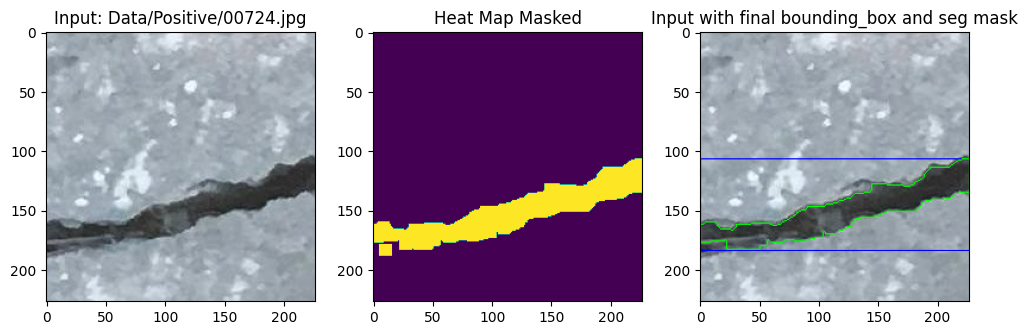

In [23]:
import cv2
from skimage import filters


image = 'Data/Positive/00724.jpg'
fig, ax = plt.subplots(ncols=3, figsize=(10,10))
img = cv2.imread(image)
ax[0].imshow(img)
title = "Input: " + image
ax[0].set_title(title)
plt.tight_layout()


gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
se = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10), (-1, -1))
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, se)
ax[1].imshow(binary)
ax[1].set_title('Heat Map Masked')



contours,hierachy=cv2.findContours(binary,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
height, width = img.shape[:2]
for c in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[c])
    area = cv2.contourArea(contours[c])
    if h > (height//2):
        continue
    if area < 150:
        continue
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 1, 8, 0)
    cv2.drawContours(img, contours, c, (0, 255, 0), 1, 8)
ax[2].imshow(img)
ax[2].set_title('Input with final bounding_box and seg mask')


In [24]:
# Create method to encompass this workflow and export the final contours


def make_seg_mask(image):
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    se = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10), (-1, -1))
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, se)
    np.array(binary)
    return binary


In [25]:
# Create seg_mask_column
pred_train_df['mask'] = pred_train_df.File_Path.apply(make_seg_mask)


In [26]:
pred_train_df.head()

,File_Path,Predicted_Label,mask
32823,Data/Negative/01239.jpg,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
16298,Data/Positive/12557_1.jpg,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
28505,Data/Positive/02427.jpg,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
6689,Data/Negative/11750.jpg,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
26893,Data/Negative/05753.jpg,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


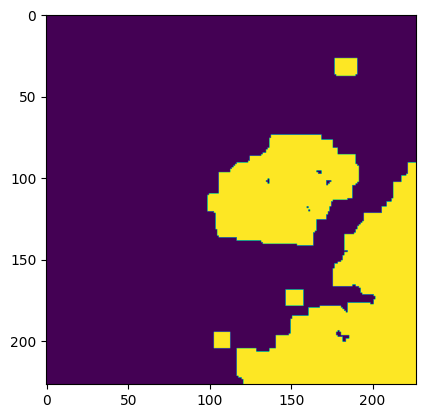

In [27]:
plt.imshow(pred_train_df.iloc[0]['mask'])

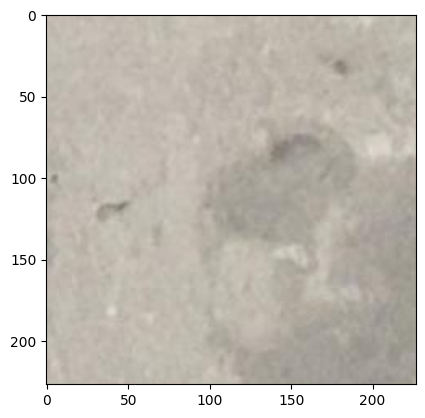

In [28]:
plt.imshow(plt.imread(pred_train_df.iloc[0]['File_Path']))

In [29]:
# # Create new datagen object from the modified test_df 
# test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#                        rescale=1./image_color_channel_size,)
# test_gen = test_datagen.flow_from_dataframe(
#     dataframe=pred_df,
#     x_col='File_Path',
#     y_col='Label',
#     target_size=(100,100),
#     color_mode='rgb',
#     class_mode='categorical',
#     batch_size=batch_size,
#     shuffle=False
# )

In [30]:
# pred_test_gen = test_datagen.flow_from_dataframe(
#         dataframe=pred_df,
#         x_col='File_Path',
#         y_col='Predicted_Label',
#         target_size=(100,100),
#         color_mode='rgb',
#         class_mode='categorical',
#         batch_size=batch_size,
#         shuffle=False
# # )   

In [31]:
# len(pred_test_gen) # 63
# pred_test_gen[0][0].shape #(128, 100, 100, 3)

In [32]:
# print(len(test_gen)) # 63
# print(pred_test_gen[0][0].shape) #(128, 100, 100, 3)

In [33]:
#Create segmentation_network
def make_segmentation_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same')(inputs)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2DTranspose(64, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3,3), padding='same', activation='relu')(x)
    outputs = tf.keras.layers.Conv2DTranspose(num_classes, kernel_size=(1,1), activation='sigmoid')(x)
    return tf.keras.Model(inputs, outputs)


# Create the second network
segmentation_model = make_segmentation_model(input_shape=image_size + (3,), num_classes=2)

# Compile the second network
segmentation_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [34]:
segmentation_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 100, 32)      9248      
                                                                 
 activation_3 (Activation)   (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 50, 64)        18496     
                                                           

In [35]:
# Fit the second network
history = segmentation_model.fit(pred_test_gen, epochs=50, batch_size=32, validation_data=pred_test_gen, callbacks=[until_max_callbacks])

NameError: name 'pred_test_gen' is not defined

In [ ]:
# Make predictions on the test set
segmentation_predictions = segmentation_model.predict(x_test)

# Create masks based on the predictions from the second model
segmentation_masks = (segmentation_predictions > 0.5).astype(int)

In [ ]:
# Visualize the masks and calculate TP, FP, FN, and TN
for i in range(test_gen.shape[0]):
    image = test_images[i]
    mask = segmentation_masks[i]
    ground_truth = test_labels_segmentation[i]
    
    TP = np.sum((mask == 1) & (ground_truth == 1))
    FP = np.sum((mask == 1) & (ground_truth == 0))
    FN = np.sum((mask == 0) & (ground_truth == 1))
    TN = np.sum((mask == 0) & (ground_truth == 0))
    
    # Visualize the image, mask, and ground truth
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(image)
    plt.title('Image')
    plt.subplot(132)
    plt.imshow(mask)
    plt.title('Mask')
    plt.subplot(133)
    plt.imshow(ground_truth)
    plt.title('Ground Truth')
    plt.show()
    print("True Positives:", TP)
    print("False Positives:", FP)
    print("False Negatives:", FN)
    print("True Negatives:", TN)